In [1]:
import torch
import wandb
from hydra import compose, initialize
from torch.utils.data import DataLoader

from src.utils.load import load_dvinp
from src.utils.visualize import visualize_dvinp_both
from src.components.dvi.cmcd import CMCD

In [2]:
try:
    import torch_directml
    device = torch_directml.device() 
except ImportError:
    device = torch.device("cpu") 

In [3]:
dir = "../pretrained" # "../models/floral-serenity-8"  # 

In [4]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="cfg")
    dvinp, trainer = load_dvinp(cfg, dir, device, decoder_only=True, train_decoder=False)

    dvinp.cdvi = CMCD(
        device=device, 
        z_dim=cfg.common.z_dim,
        num_steps=128,
        control=None,
    )

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 289921.35it/s]
Dropped Escape call with ulEscapeCode : 0x03007703


loaded decoder from ../pretrained/dvinp.pth


In [ ]:
trainer.wandb_logging = True
if trainer.wandb_logging:
    wandb.init(project="pretrained-decoder")

# trainer.optimizer.param_groups[0]["lr"] = 0.2 * cfg.training.learning_rate
# print(trainer.optimizer.param_groups[0]["lr"])

num_epochs = 50
losses = trainer.train(
    num_epochs=num_epochs,
    max_clip_norm=cfg.training.max_clip_norm,
    alpha=cfg.training.alpha,
    validate=True
)

torch.save(dvinp.state_dict(), f"{dir}/dvinp_informed_64.pth")

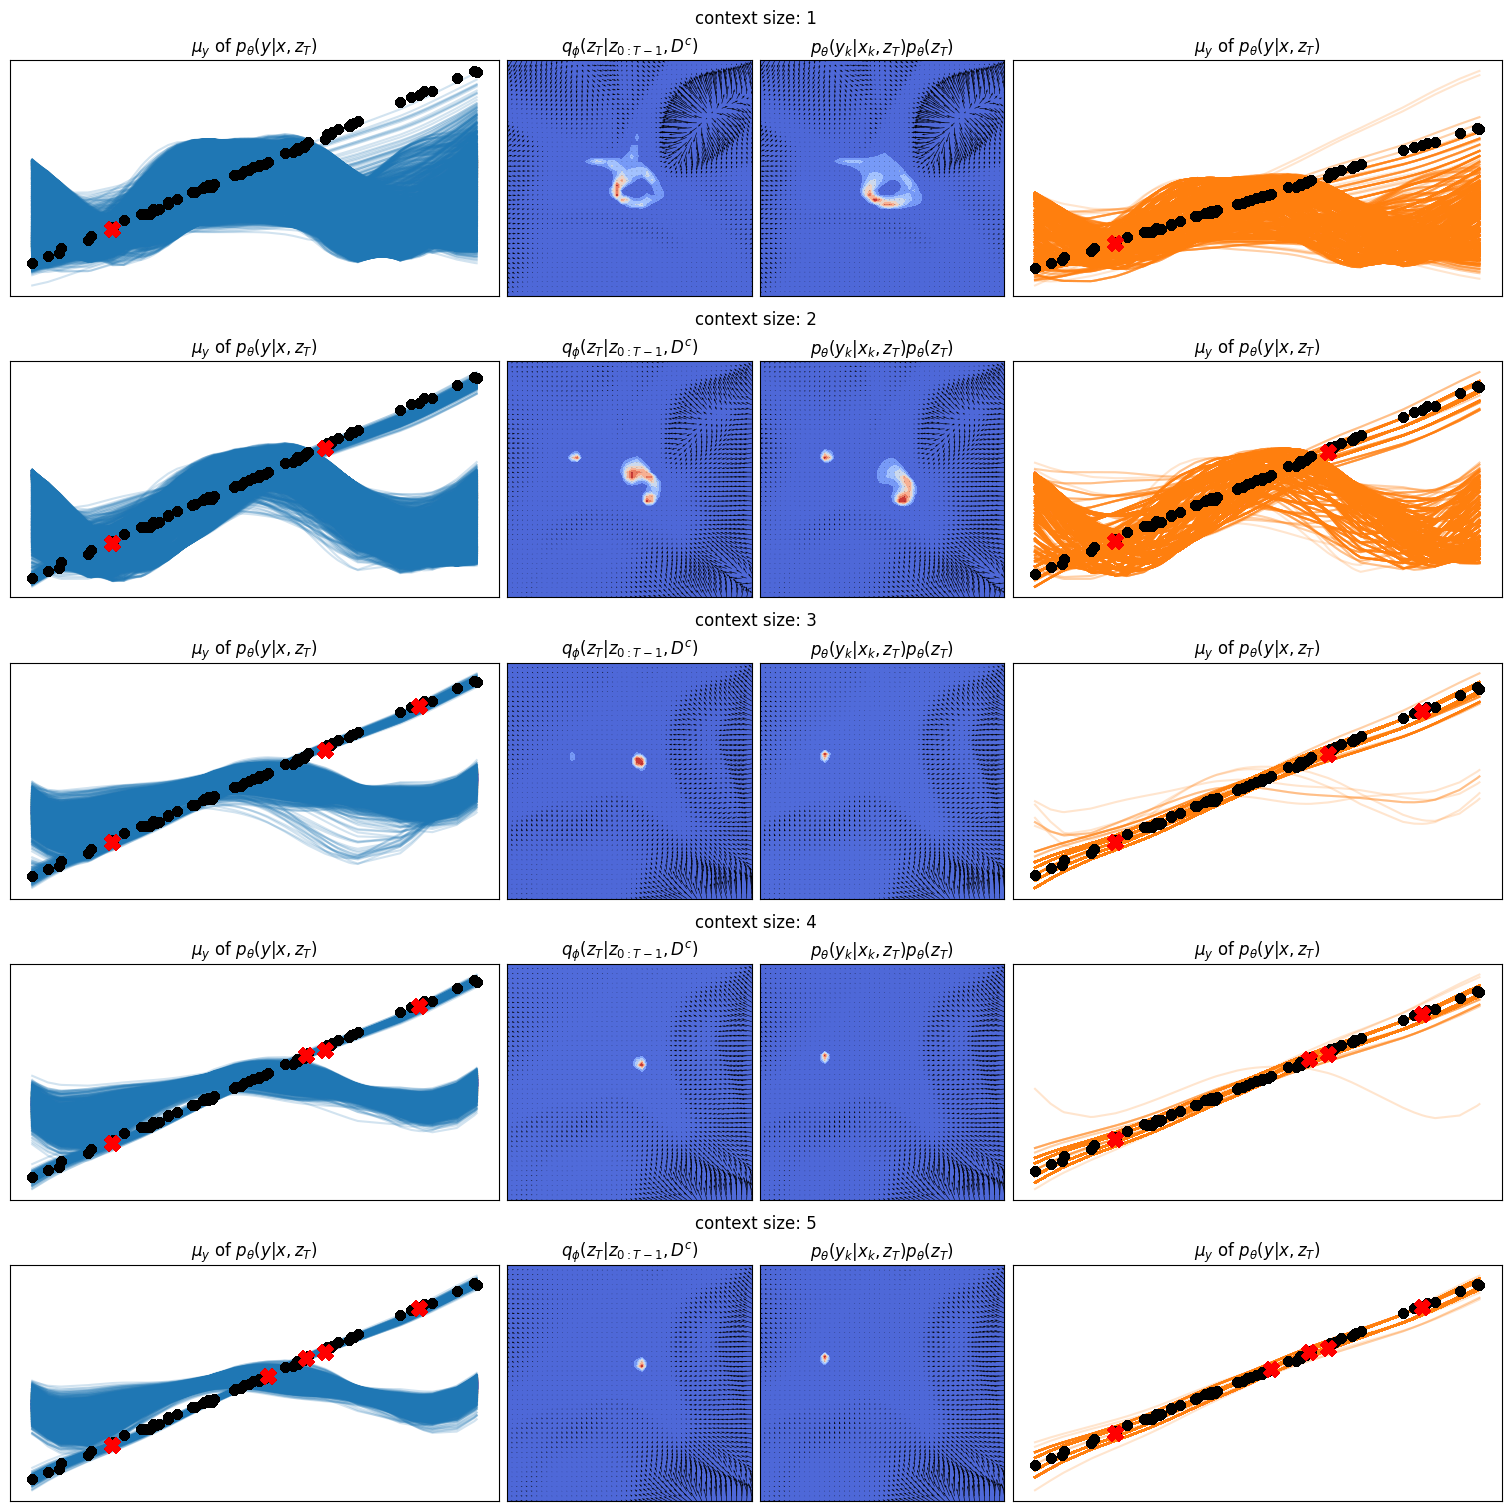

In [6]:
max_context_size = 5
num_samples = 2500 # num_cells will be root
gen_dataloader = DataLoader(trainer.dataset, 1, False, generator=trainer.train_loader.generator)

ranges = [(-5, 5), (-5, 5)]

targets, samples = visualize_dvinp_both(
    device=device,
    dvinp=dvinp,
    dataloader=gen_dataloader,
    num_samples=num_samples,
    max_context_size=max_context_size,
    ranges=ranges,
)